# Analyzing Land Cover Change Using NLCD Data

In [320]:
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from time import sleep

In [321]:
src2011 = rasterio.open('C:\\Users\samfa\\Documents\\geog490\\bru\\clip2011.tif')
src2013 = rasterio.open('C:\\Users\samfa\\Documents\\geog490\\bru\\clip2013.tif')
src2016 = rasterio.open('C:\\Users\samfa\\Documents\\geog490\\bru\\clip2016.tif')
src2019 = rasterio.open('C:\\Users\samfa\\Documents\\geog490\\bru\\clip2019.tif')


## Data Preprocessing

In [322]:
nlcd_2011 = src2011.read(1)
nlcd_2013= src2013.read(1)
nlcd_2016 = src2016.read(1)
nlcd_2019 = src2019.read(1)


### Mask Developed LCC

In [323]:
nlcd_2011[(nlcd_2011 == 24) | (nlcd_2011 == 23) | (nlcd_2011 == 22)] = 21
nlcd_2013[(nlcd_2013 == 24) | (nlcd_2013 == 23) | (nlcd_2013 == 22)] = 21
nlcd_2016[(nlcd_2016 == 24) | (nlcd_2016 == 23) | (nlcd_2016 == 22)] = 21
nlcd_2019[(nlcd_2019 == 24) | (nlcd_2019 == 23) | (nlcd_2019 == 22)] = 21

### Create Land Class name dictionary

In [324]:
lc_names = {
    11: 'Open Water',
    21: 'Developed',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grasslands/Herbaceous',  
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands',
}


In [325]:
for nlcd in [nlcd_2011, nlcd_2013, nlcd_2016, nlcd_2019]:
    nlcd[np.where((nlcd == 90) & (nlcd == 95))] = 71

# Visualization

### Create LC Color list 

In [326]:
colors = [
    'blue',    # Open Water
    'gray',    # Developed
    'yellow',  # Barren Land
    'green',   # Deciduous Forest
    'darkgreen', # Evergreen Forest
    'lime',    # Mixed Forest
    'orange',  # Shrub/Scrub
    'lightgreen',  # Grassland/Herbaceous
    'lightgreen',  # Woody Wetlands
    'lightgreen',    # Emergent Herbaceous Wetlands
]

cmap = ListedColormap(colors)
bounds = np.array(list(lc_names.keys()))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


### Plot NLCD  Data with Colorbar

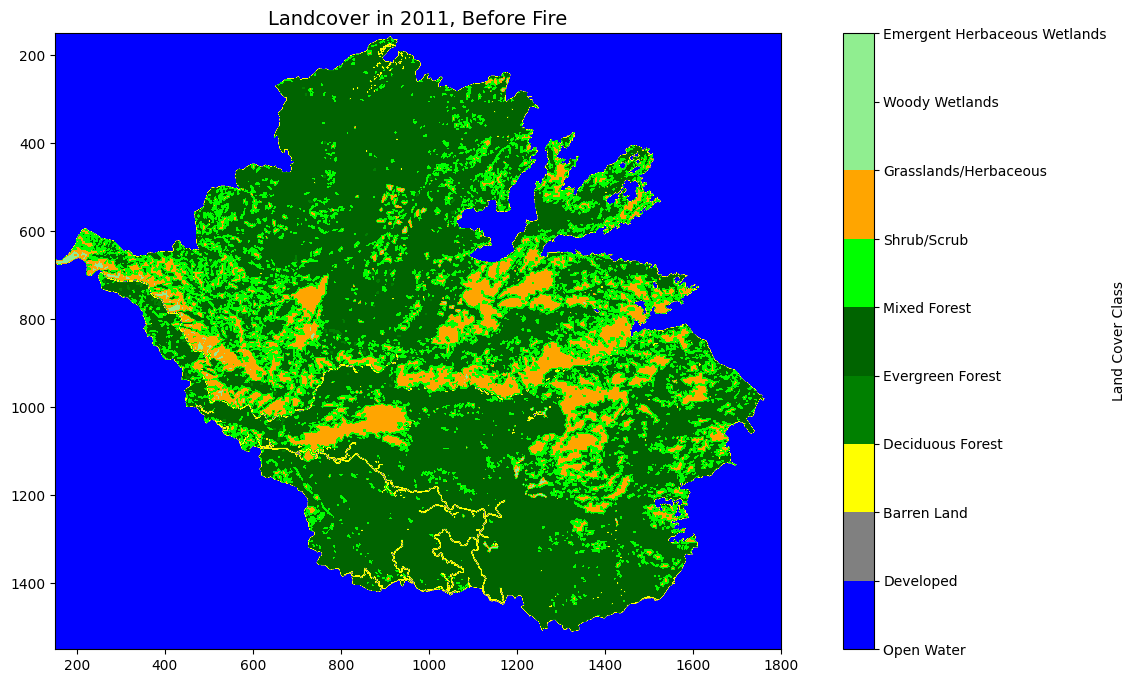

In [327]:
def plot_land_cover(data, title):
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(data, cmap=cmap, norm=norm)
    ax.set_xlim(150, 1800)
    ax.set_ylim(1550, 150)
    ax.set_title(title, fontsize=14)

    cbar = fig.colorbar(im, ax=ax, ticks=bounds, boundaries=bounds)
    cbar.ax.set_yticklabels(list(lc_names.values()))
    cbar.set_label('Land Cover Class')

    plt.show()

plot_land_cover(nlcd_2011, "Landcover in 2011, Before Fire")



## Calculate  Counts and Percent Class then transform into DF

In [328]:
unique_11, counts_11 = np.unique(nlcd_2011, return_counts=True)
lc_counts11 = dict(zip(unique_11, counts_11))

unique_13, counts_13 = np.unique(nlcd_2013, return_counts=True)
lc_counts13 = dict(zip(unique_13, counts_13))

unique_16, counts_16 = np.unique(nlcd_2016, return_counts=True)
lc_counts16 = dict(zip(unique_16, counts_16))

unique_19, counts_19 = np.unique(nlcd_2019, return_counts=True)
lc_counts19 = dict(zip(unique_19, counts_19))

for lc_counts in [lc_counts11, lc_counts13, lc_counts16, lc_counts19]:
    lc_counts.pop(0, None)
    lc_counts.pop(255, None)
    lc_counts.pop(-1, None)
unique_11 = np.array(list(lc_counts11.keys()))
unique_13 = np.array(list(lc_counts13.keys()))
unique_16 = np.array(list(lc_counts16.keys()))
unique_19 = np.array(list(lc_counts19.keys()))

land_pixels = (nlcd_2011.size - 1915853)

df_2011 = pd.DataFrame(list(zip(unique_11, lc_counts11.values(), (np.array(list(lc_counts11.values()))/land_pixels)*100)), 
                       columns=['lc', 'count_2011', 'fraction_2011'])


df_2013 = pd.DataFrame(list(zip(unique_13, lc_counts13.values(), (np.array(list(lc_counts13.values()))/land_pixels)*100)), 
                       columns=['lc', 'count_2013', 'fraction_2013'])

df_2016 = pd.DataFrame(list(zip(unique_16, lc_counts16.values(), (np.array(list(lc_counts16.values()))/land_pixels)*100)), 
                       columns=['lc', 'count_2016', 'fraction_2016'])

df_2019 = pd.DataFrame(list(zip(unique_19, lc_counts19.values(), (np.array(list(lc_counts19.values()))/land_pixels)*100)), 
                       columns=['lc', 'count_2019', 'fraction_2019'])

### Add LC names to Dataframes

In [329]:
df_2011['lc_name'] = df_2011['lc'].map(lc_names)
df_2013['lc_name'] = df_2013['lc'].map(lc_names)
df_2016['lc_name'] = df_2016['lc'].map(lc_names)
df_2019['lc_name'] = df_2019['lc'].map(lc_names)

In [330]:
def merge_and_calculate(df1, df2, year1, year2):
    merged_df = df1[['lc', f'count_{year1}', f'fraction_{year1}']].merge(df2[['lc', f'count_{year2}', f'fraction_{year2}']], on='lc', how='outer')
    merged_df.fillna(0, inplace=True)
    merged_df[f'change_fraction_{year1}_{year2}'] = merged_df[f'fraction_{year2}'] - merged_df[f'fraction_{year1}']
    merged_df[f'change_counts_{year1}_{year2}'] = merged_df[f'count_{year2}'] - merged_df[f'count_{year1}']
    merged_df['lc_name'] = merged_df['lc'].map(lc_names)
    return merged_df

merged_11_13 = merge_and_calculate(df_2011, df_2013, 2011, 2013)
merged_11_16 = merge_and_calculate(df_2011, df_2016, 2011, 2016)
merged_11_19 = merge_and_calculate(df_2011, df_2019, 2011, 2019)
merged_13_16 = merge_and_calculate(df_2013, df_2016, 2013, 2016)
merged_13_19 = merge_and_calculate(df_2013, df_2019, 2013, 2019)
merged_16_19 = merge_and_calculate(df_2016, df_2019, 2016, 2019)

In [331]:
nlcd_2011_resized = nlcd_2011[:, :-1]
evergreen_shrub = (nlcd_2011_resized == 42) & (nlcd_2019 == 52)

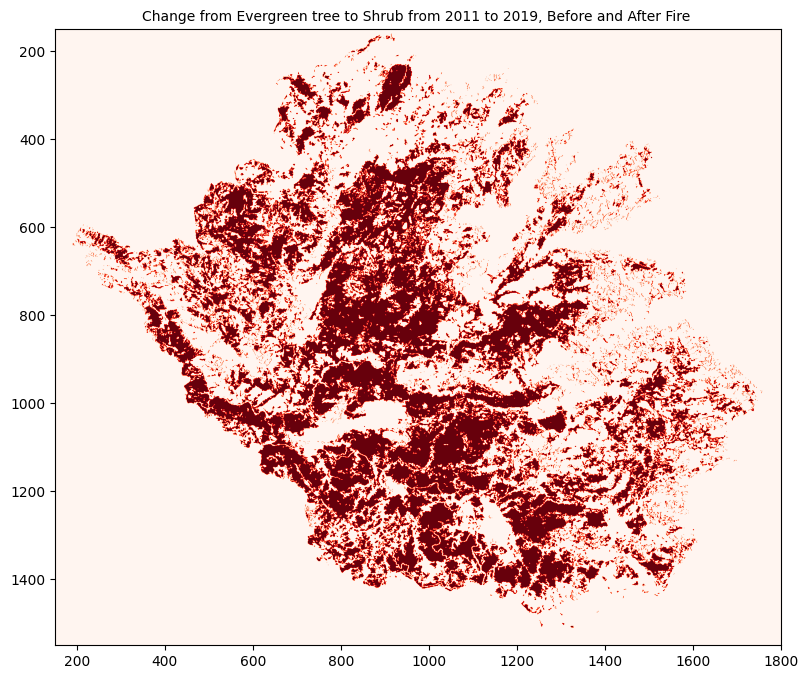

In [332]:
fig, ax = plt.subplots(figsize=(16, 8))
im2 = ax.imshow(evergreen_shrub.astype(int), cmap='Reds')
ax.set_title("Change from Evergreen tree to Shrub from 2011 to 2019, Before and After Fire ", fontsize=10)

# Set the limits for the x and y axes
ax.set_xlim(150, 1800)  # Zoom into columns 400 to 800
ax.set_ylim(1550, 150)  # Zoom into rows 500 to 800

plt.show()


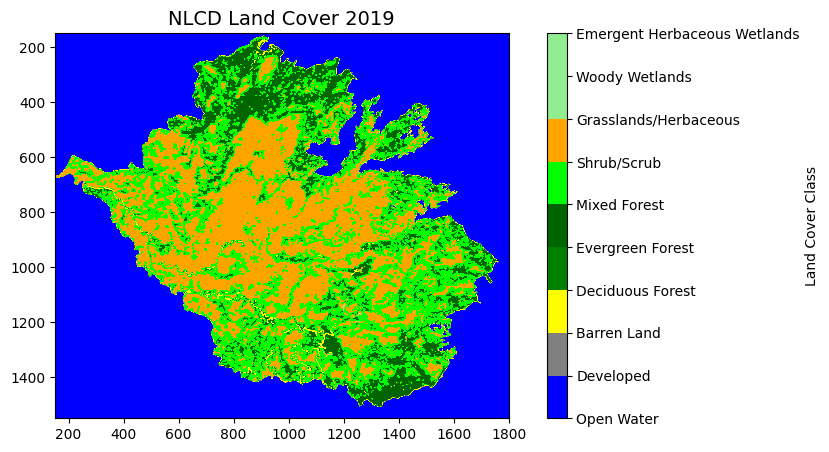

In [333]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(nlcd_2011, cmap=cmap, norm=norm)
ax.set_xlim(150, 1800)
ax.set_ylim(1550, 150)
ax.set_title('NLCD Land Cover', fontsize=14)
cbar = fig.colorbar(im, ax=ax, ticks=bounds, boundaries=bounds)
cbar.ax.set_yticklabels(list(lc_names.values()))
cbar.set_label('Land Cover Class')

# Define a function that updates the plot for each frame of the animation
def update(frame):
    if frame == 0:
        im.set_array(nlcd_2011)
        ax.set_title('NLCD Land Cover 2011', fontsize=14)
    elif frame == 1:
        im.set_array(nlcd_2013)
        ax.set_title('NLCD Land Cover 2013', fontsize=14)
    elif frame == 2:
        im.set_array(nlcd_2016)
        ax.set_title('NLCD Land Cover 2016', fontsize=14)
    else:
        im.set_array(nlcd_2019)
        ax.set_title('NLCD Land Cover 2019', fontsize=14)
    return [im]

# Create the animation using the update function and the number of frames
anim = animation.FuncAnimation(fig, update, frames=4, interval=5000, blit=True)

# Display the animation in the notebook using HTML and to_jshtml()
HTML(anim.to_jshtml())
